# Imports

In [75]:
%reset -f
%load_ext autoreload
%autoreload 2

In [76]:
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss 

import pycaret.regression as pr

from controller import Controller

In [77]:
c = Controller('i02')

cols_to_drop = [
    'PROJECT_ID',
    'TRAIN_VAL_TEST_SPLIT',
    'DEADLINE',
    'STATE_CHANGED_AT',
    'CREATED_AT',
    'LAUNCHED_AT',
    'KEYWORDS',
    
    'DESC',
    'NAME',
    'FINAL_STATUS',
]

# Load data

In [78]:
filepath = fr'{c.get_path_data_prepared()}/01_df_development.pkl'
df_development = pd.read_pickle(filepath)
df_development = df_development.drop(cols_to_drop, axis=1)
df_development

,GOAL,DISABLE_COMMUNICATION,COUNTRY,CURRENCY,BACKERS_COUNT,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS
0,60000.0,False,US,USD,4,2375.831389,7.773524,3095.831389,8.038135,720.000000
1,800.0,False,US,USD,41,119.452500,4.791255,1400.657500,7.245411,1281.205000
2,10000.0,False,US,USD,1,6345.470556,8.755654,7185.470556,8.879955,840.000000
3,270.0,False,GB,GBP,0,0.920833,0.652759,192.920833,5.267450,192.000000
4,5.0,False,GB,GBP,0,823.233611,6.714454,1544.233611,7.342930,721.000000
...,...,...,...,...,...,...,...,...,...,...
108124,250.0,False,US,USD,24,835.094444,6.728742,1373.173056,7.225607,538.078611
108125,5000.0,False,US,USD,0,285.817778,5.658847,1005.817778,6.914550,720.000000
108126,45000.0,False,CA,CAD,36,310.938611,5.742806,1030.938611,6.939194,720.000000
108127,3000.0,False,US,USD,0,152.635278,5.034581,873.635278,6.773807,721.000000


# Analyze `BACKERS_COUNT`

Skewness Initial: 89.39470644303087
Skewness Box-Cox: -0.17758967940253068
Skewness Log    : 0.28060910734673983


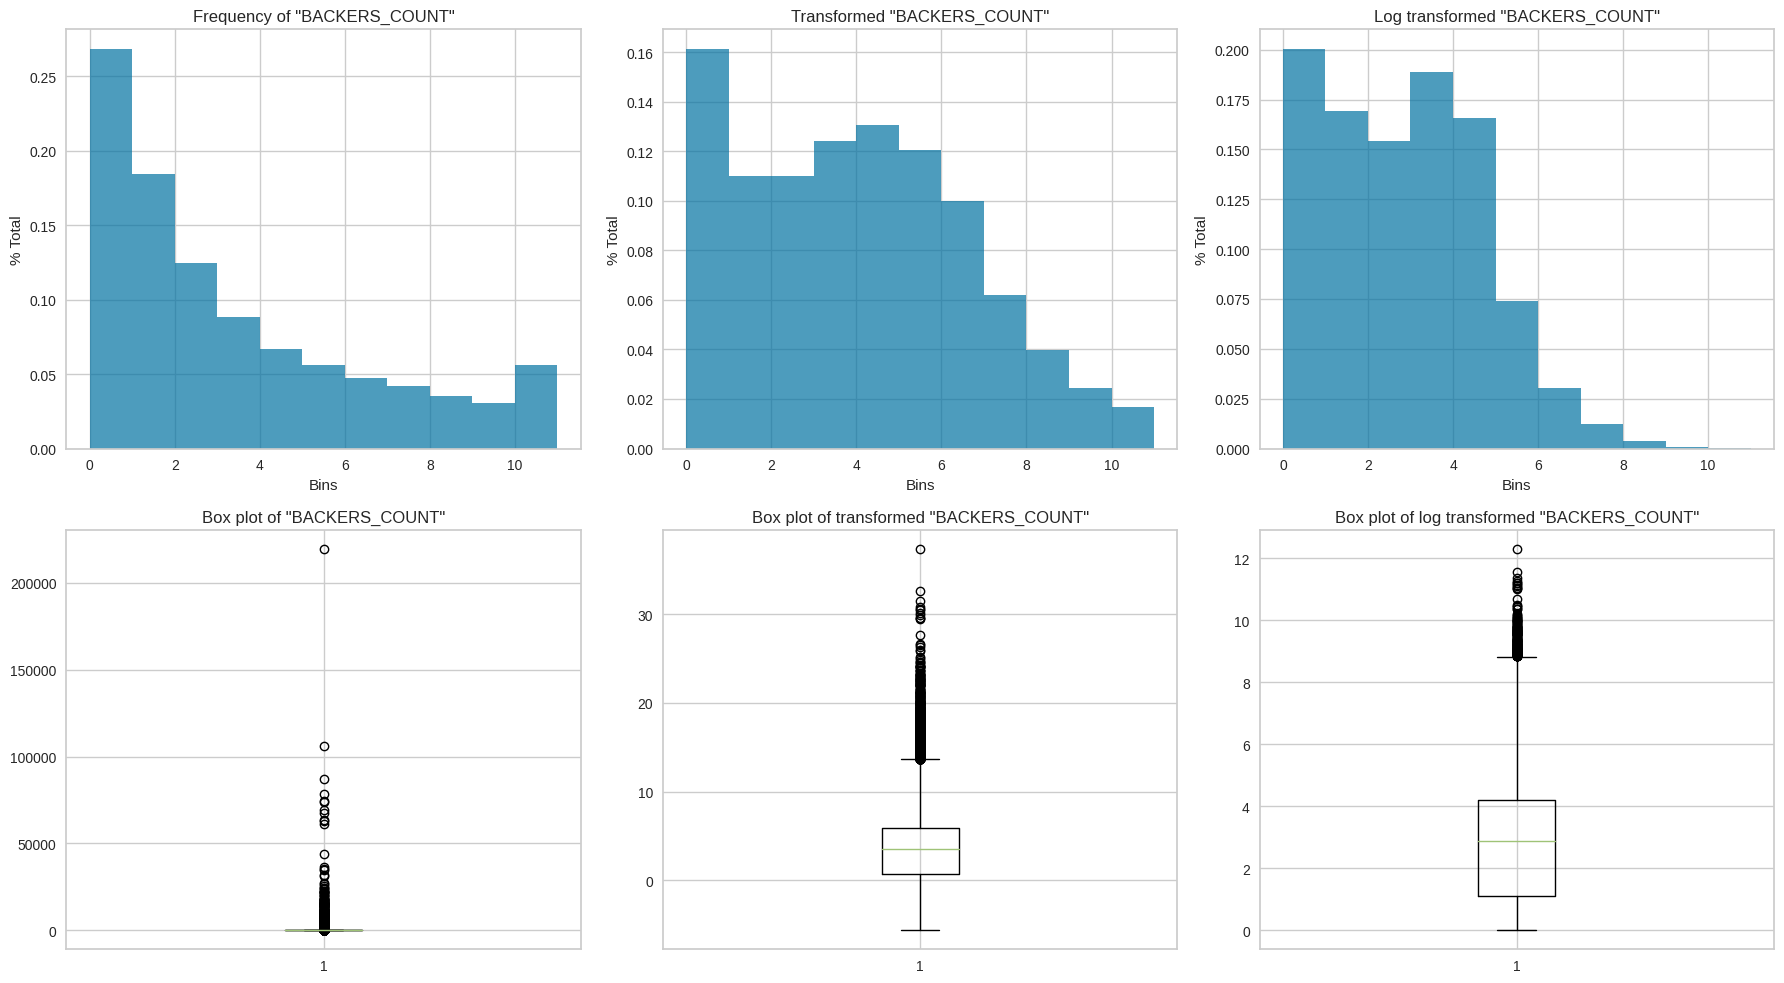

In [79]:
transformed_box_cox = pd.Series(stats.boxcox(df_development['BACKERS_COUNT']+1e-6)[0])
transformed_log = np.log1p(df_development['BACKERS_COUNT'])

print(f'Skewness Initial: {df_development["BACKERS_COUNT"].skew()}')
print(f'Skewness Box-Cox: {transformed_box_cox.skew()}')
print(f'Skewness Log    : {transformed_log.skew()}')

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].set_title('Frequency of "BACKERS_COUNT"')
axs[0, 0].hist(df_development['BACKERS_COUNT'], bins=range(12), alpha=0.7, density=True)
axs[0, 0].set_xlabel('Bins')
axs[0, 0].set_ylabel('% Total')

axs[0, 1].set_title('Transformed "BACKERS_COUNT"')
axs[0, 1].hist(transformed_box_cox, bins=range(12), alpha=0.7, density=True)
axs[0, 1].set_xlabel('Bins')
axs[0, 1].set_ylabel('% Total')

axs[0, 2].set_title('Log transformed "BACKERS_COUNT"')
axs[0, 2].hist(transformed_log, bins=range(12), alpha=0.7, density=True)
axs[0, 2].set_xlabel('Bins')
axs[0, 2].set_ylabel('% Total')

axs[1, 0].set_title('Box plot of "BACKERS_COUNT"')
axs[1, 0].boxplot(df_development['BACKERS_COUNT'])

axs[1, 1].set_title('Box plot of transformed "BACKERS_COUNT"')
axs[1, 1].boxplot(transformed_box_cox)

axs[1, 2].set_title('Box plot of log transformed "BACKERS_COUNT"')
axs[1, 2].boxplot(transformed_log)

plt.tight_layout()
plt.show()

# Run PyCaret

In [ ]:
s1 = setup(data=df_development, train_size=0.8, target='FINAL_STATUS', session_id=42)

In [ ]:
remove_metric('Kappa')
remove_metric('Accuracy')
add_metric('logloss', 'Log Loss', log_loss, greater_is_better=False)
get_metrics()

In [ ]:
best = compare_models(sort='MCC', n_select=10)

In [ ]:
best

# Evaluate models

## Bag top 3 models

In [ ]:
tuned_top = [tune_model(i, optimize='MCC') for i in best[:4]]

## Find best overall model

In [ ]:
blender = blend_models(tuned_top, optimize='MCC')
stacker = stack_models(tuned_top, optimize='MCC')
best_overall_model = automl(optimize='MCC')

# Hard Voting Classifier, i.e. majority wins
best_overall_model

In [ ]:
predict_holdout = predict_model(best_overall_model)
predict_holdout

In [ ]:
plot_model(best_overall_model, plot='confusion_matrix')

In [ ]:
plot_model(best_overall_model, plot='class_report')

In [ ]:
plot_model(best_overall_model, plot='error')

## Single best  model

In [ ]:
best[0]

In [ ]:
lgbm_tuned = tune_model(best[0], optimize='MCC')

# Saving to files

In [ ]:
filename = fr'{c.get_path_iteration()}/pycaret_best_single_model'
save_model(lgbm_tuned, filename)

In [ ]:
filename = fr'{c.get_path_iteration()}/pycaret_best_overall_model'
save_model(best_overall_model, filename)